In [1]:
import collections
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import seaborn as sns

import networkx as nx
from networkx.algorithms import community

import cc_graph_ops

In [2]:
INPUT_FILE = 'fdg_input_file.json'

In [3]:
# Takes ~1 min to execute.
g = cc_graph_ops.create_graph_from_file(INPUT_FILE)

In [4]:
print("Num nodes:", len(g.nodes()))
print("Num edges:", len(g.edges()))

Num nodes: 235863
Num edges: 4148787


## Overall License Composition

In [5]:
licenses = cc_graph_ops.get_licenses(g)
usages = collections.defaultdict(int)
for node_id, cc_licenses in g.nodes(data='cc_licenses'):
    for license in cc_licenses:
        usages[license] += cc_licenses[license]

licenses = list(licenses)
licenses.sort(key=lambda lisc: usages[lisc], reverse=True)

In [6]:
total = sum([usage for license, usage in usages.items()])
template = "{:<24}\t{:>10}\t{:>10.3f}%"
print("{:<24}\t{:>10}\t{:>11}".format("License", "Usage", "Proportion"))
for license, usage in sorted(list(usages.items()), key=lambda x: x[1], reverse=True)[:30]:
    print(template.format(license, usage, 100*usage/total))

License                 	     Usage	 Proportion
('by-sa', '3.0')        	  11089625	    25.981%
('by', '4.0')           	   4861536	    11.390%
('by-sa', '4.0')        	   4234494	     9.921%
('by-nc-sa', '3.0')     	   3762802	     8.816%
('by-nc-nd', '3.0')     	   3339711	     7.824%
('by-nc-sa', '4.0')     	   2689421	     6.301%
('by', '3.0')           	   2287805	     5.360%
('by-nc-nd', '4.0')     	   2273309	     5.326%
('by-nc', '4.0')        	   1037592	     2.431%
('by-nc-nd', '2.5')     	   1027532	     2.407%
('cc0', '1.0')          	    810185	     1.898%
('by-nc', '3.0')        	    769604	     1.803%
('by-nc-sa', '2.5')     	    732736	     1.717%
('by', '2.5')           	    469121	     1.099%
('by-nc-sa', '2.0')     	    464072	     1.087%
('by', '2.0')           	    455903	     1.068%
('by-nc-nd', '2.0')     	    394289	     0.924%
('by-nd', '3.0')        	    384638	     0.901%
('by-sa', '2.0')        	    374371	     0.877%
('by-nc', '2.5')        	    237377	    

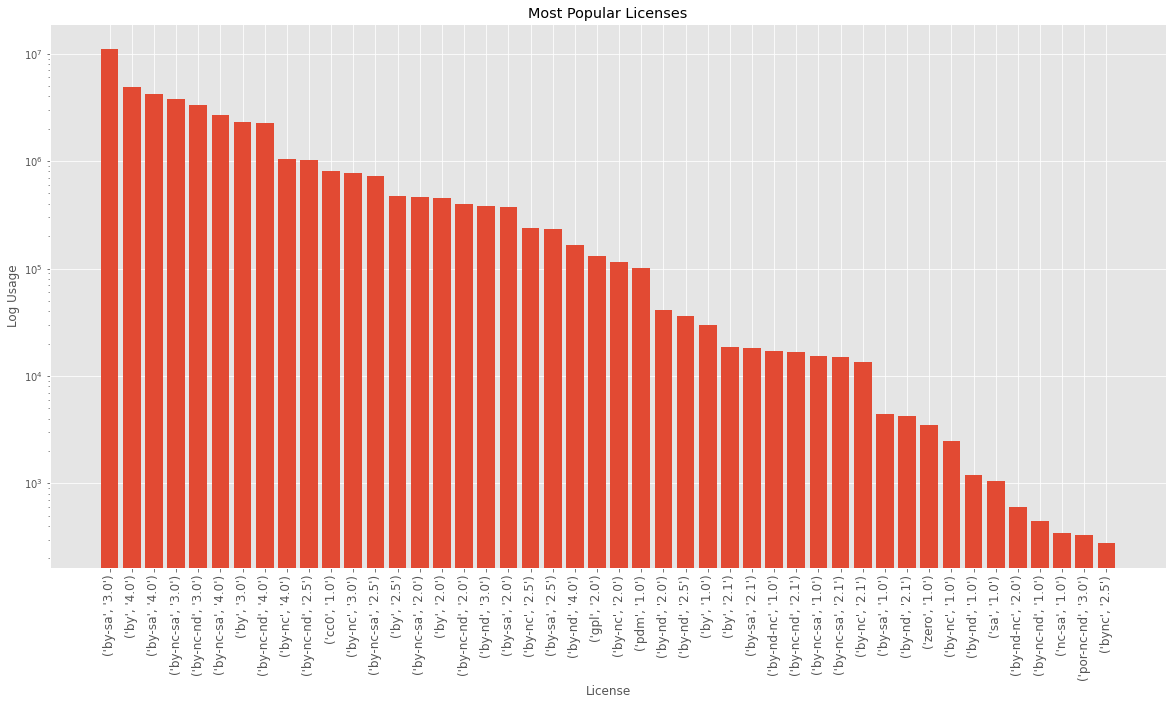

R2: 0.979


In [7]:
licenses = sorted(list(licenses), key=lambda x: -usages[x])
important_licenses = list(filter(lambda x: usages[x] > 100, licenses))

plt.rcParams['figure.figsize'] = [20, 10]
plt.style.use('ggplot')
y = [usages[i] for i in important_licenses]
plt.bar(important_licenses, y, log=True)
plt.xticks(rotation=90, fontsize='large')
plt.xlabel("License")
plt.ylabel("Log Usage")
plt.title("Most Popular Licenses")
plt.show()

_, _, rvalue, _, _ = scipy.stats.linregress(np.arange(1, len(y)+1), np.log(np.array(y)))
print("R2:", round(rvalue**2, 3))

We see that the distribution of licenses is very skewed. This is to be expected, as some licenses are more going to be more versatile and more popular than others. We see that `by-sa 3.0` (Attribution-ShareAlike 3.0) is by far the most popular license, accounting for over 25% of all Creative Commons licenses. The top 8 licenses account for 81% of the data, and any license outside the top 16 accounts for less than 1% of the dataset. Anything outside of the top 46 has less than 100 appearances and accounts for less than 0.001% of the dataset. Also, we notice that there is a strong exponential relationship between the rank of the license and it's usage ($R^2=.97$ for a linear regression of log Usage versus rank). 

## Local License Attributes

Now, we consider how licenses are distributed at the node level. For example, how many different works does the average domain have? How are these works distributed among license types? Do domains generally use only a single license type, or are the different license types randomly distributed among domains?

In [8]:
all_cc_licenses = cc_graph_ops.cc_licenses_by_domain(g)

In [9]:
mult_licenses = 0
single_work = 0
zero_works = 0
ge_five_works = 0
predominanly_single_license = 0

all_cc_licenses = cc_graph_ops.cc_licenses_by_domain(g)
for node_id, cc_licenses in all_cc_licenses.items():
    if len(cc_licenses) > 1:
        mult_licenses += 1
    licenses_qty = sum(cc_licenses.values())
    if licenses_qty == 1:
        single_work += 1
    if licenses_qty >= 5:
        ge_five_works += 1

    for license in cc_licenses:
        total_licenses = sum(cc_licenses.values())
        if cc_licenses[license] > 0.75*total_licenses:
            predominanly_single_license += 1

template = "{:<40} {:>10} {:>20}%"
template2 = "{:>73}"
total_domains = len(g.nodes())
print(template2.format("Proportion"))
print(template.format("Num domains w/ CC works:", len(all_cc_licenses), round(100*len(all_cc_licenses)/total_domains, 2)))
print(template.format("Num domains w/ > 1 license type:", mult_licenses, round(100*mult_licenses/total_domains,2)))
print(template.format("Num domains w/ exactly 1 CC work:", single_work, round(100*single_work/total_domains,2)))
print(template.format("Num domains w/ >= 5 CC works:", ge_five_works, round(100*ge_five_works/total_domains,2)))
print(template.format("Num domains w/ predominantly* 1 license:", predominanly_single_license,
                      round(100*predominanly_single_license/total_domains,2)))
print()
print("* over 75% of works are of the same license")

                                                               Proportion
Num domains w/ CC works:                     225260                 95.5%
Num domains w/ > 1 license type:              45331                19.22%
Num domains w/ exactly 1 CC work:             85436                36.22%
Num domains w/ >= 5 CC works:                 99238                42.07%
Num domains w/ predominantly* 1 license:     194518                82.47%

* over 75% of works are of the same license


26% of domains in the dataset only contain one work licensed by Creative Commons. It is unlikely that these nodes will matter very much when we do our impact analysis. However, we also see that 20% of domains use more than one difference license types, meaning the remaining 54% of domains have multiple CC licensed works all under the same license. Furthermore, we see that 87% of domains predominantly use one license. I run some $\chi^2$ goodness of fit tests below to see if there is an overall tendency to host a few types of licenses, or if licenses are more or less randomly distributed.

In [10]:
total_usages = sum([total for license, total in usages.items()])
most_popular_licenses = list(filter(lambda x: usages[x]/total_usages > 0.05, licenses))
p = [usages[license]/total_usages for license in most_popular_licenses]

print("Most popular licenses:", most_popular_licenses)
chi2_vals = []
pvals = []
qtys = []
for node_id, cc_licenses in all_cc_licenses.items():
    obs = []
    for i, license in enumerate(most_popular_licenses):
        if license in cc_licenses:
            obs.append(cc_licenses[license])
        else:
            obs.append(0)
    
    qty = sum(cc_licenses.values())
    exp = [p[i]*qty for i in range(len(obs))]

    if sum(exp) > 100:
        obs = np.array(obs)
        exp = np.array(exp)

        res = scipy.stats.chisquare(obs, exp)
        chi2_vals.append(res.statistic)
        pvals.append(res.pvalue)
        qtys.append(qty)

Most popular licenses: ["('by-sa', '3.0')", "('by', '4.0')", "('by-sa', '4.0')", "('by-nc-sa', '3.0')", "('by-nc-nd', '3.0')", "('by-nc-sa', '4.0')", "('by', '3.0')", "('by-nc-nd', '4.0')"]


In [11]:
chi2_avg = 0
pvals_avg = 0
for i in range(len(qtys)):
    chi2_avg += chi2_vals[i] * qtys[i]
    pvals_avg += pvals[i] * qtys[i]
chi2_avg /= len(qtys)
pvals_avg /= len(qtys)

template = "{:<30}{:>10.3G}"
print("{:<30}{:>10}".format("Domains Analyzed:", len(qtys)))
print(template.format("Weighted avg chi-squared:", chi2_avg))
print(template.format("Unweighted avg chi-squared:", sum(chi2_vals)/len(chi2_vals)))
print(template.format("Weighted avg p-value:", pvals_avg))
print(template.format("Unweighted avg p-value:", sum(pvals)/len(pvals)))

Domains Analyzed:                  27688
Weighted avg chi-squared:       3.46E+09
Unweighted avg chi-squared:     9.04E+03
Weighted avg p-value:           8.37E-08
Unweighted avg p-value:         5.47E-10


Regardless of how we weight the average, it turns out that the the $p$-values for our $\chi^2$-test are extremely small. Thus, we can conclude that domains do not select licenses for the works they host at random. Instead, it is more likely for a domain to host works of only a few different licenses.

For some technical details, we did the computation for only the top 8 most popular licenses and those domains with more than 100 licenses labeled, which means we are only at around 12% of the overall dataset. Both of these restrictions are so that our expected count data for each license type is above 5 for each license type, which is the minimum recommended for applying a $\chi^2$-test. We could alternatively opt for the exact multinomial test, but this would be very computationally expensive, especially if we want to consider more than just the top 8 licenses. 

#### License Attributes for Popular Domains

We now focus our attention to those domains with the most CC-licensed works.

In [12]:
licenses_qty = collections.defaultdict(int)

for node_id, cc_licenses in all_cc_licenses.items():
    for lisc, qty in cc_licenses.items():
        licenses_qty[node_id] += qty

sorted_domains = list(licenses_qty.items())
sorted_domains.sort(key=lambda x: x[1], reverse=True)

In [13]:
mult_lisc_domains = []

print("Looking at large domains that have 98% of works with the same license")
template = "{:<20}{:<20}{:>10} {:>10.3f}%"
print("{:<20}{:<20}{:>10} {:>10}".format("Domain", "License", "Count", "Prop"))
for domain, _ in sorted_domains[:100]:
    cc_licenses = g.nodes[domain]['cc_licenses']    
    xlabels = []
    heights = []
    for lisc, qty in cc_licenses.items():
        xlabels.append(lisc)
        heights.append(qty)
    xlabels.sort(key=lambda x: cc_licenses[x], reverse=True)
    heights.sort(reverse=True)
    
    total = sum(heights)    
    if heights[0] > 0.98*total:
        print(template.format(domain, xlabels[0], total, 100 * heights[0]/usages[xlabels[0]]))
    else:
        mult_lisc_domains.append(domain)

Looking at large domains that have 98% of works with the same license
Domain              License                  Count       Prop
wikipedia           ('by-sa', '3.0')       5340549     48.119%
stackexchange       ('by-sa', '4.0')       1228722     28.994%
wiktionary          ('by-sa', '3.0')        564437      5.089%
wikisource          ('by-sa', '3.0')        296031      2.662%
wikiquote           ('by-sa', '3.0')        183751      1.657%
globalvoices        ('by', '3.0')           123121      5.353%
wikibooks           ('by-sa', '3.0')        108649      0.977%
stackoverflow       ('by-sa', '4.0')        108560      2.556%
google              ('by', '4.0')           103215      2.112%
ifixit              ('by-nc-sa', '3.0')      86196      2.290%
dbpedia             ('by-sa', '3.0')         58892      0.531%
europa              ('by', '2.5')            57168     12.099%
formez              ('by-sa', '4.0')         55177      1.289%
ingv                ('by', '4.0')            5351

In [14]:
lisc_10_pct_single_domain = []
for domain, _ in sorted_domains:
    cc_licenses = g.nodes[domain]['cc_licenses']
    for lisc in cc_licenses:
        if cc_licenses[lisc] > 0.10 * usages[lisc]:
            lisc_10_pct_single_domain.append((lisc, 
                                             usages[lisc], 
                                             domain, 
                                             100 * cc_licenses[lisc]/usages[lisc]))

"""It's only interesting if a liscense is dominated by a domain
if that license is sufficiently large.
We threshold at 1000 usages for that license.
"""
lisc_10_pct_single_domain = list(filter(lambda x: x[1] > 1000, lisc_10_pct_single_domain))
for t in lisc_10_pct_single_domain:
    print("{:<20}{:>10}{:>20}{:>10.3f}".format(*t))

('by-sa', '3.0')      11089625           wikipedia    48.119
('by-sa', '4.0')       4234494       stackexchange    28.994
('by-nd', '3.0')        384638           wordpress    20.463
('by-nd', '2.5')         35781            blogspot    17.965
('by-nd-nc', '1.0')      17183            blogspot    10.580
('by-nc-nd', '2.5')    1027532            blogspot    11.783
('by-nc', '2.5')        237377            blogspot    34.191
('by', '2.5')           469121            wikinews    19.731
('by', '2.5')           469121              europa    12.099
('by-nc-nd', '2.0')     394289              sherpa    12.688
('gpl', '2.0')          129596              tuwien    18.799
('by', '1.0')            30028               xwiki    67.567
('by-nc', '2.0')        114218                aadl    14.309
('pdm', '1.0')          101682   publicdomainfiles    12.118
('by-nd-nc', '1.0')      17183           indymedia    16.819
('by-sa', '2.1')         18105                oops    49.301
('by-nc-sa', '1.0')     

Some observations: We see that many of the domains that have the most CC works almost exclusively use one type of license. There isn't an immediately obvious correlation between the type of institution and the license they use; for example, we see UCLA and Uni Trier use different licenses despite both being college websites. 

However, one thing to note that Wikipedia accounts for almost half of all uses of the `by-sa 3.0` license. (Similarly, StackExchange accounts for a quarter of the usage of the `by-sa 4.0` license.) Perhaps in future analysis, we should consider controlling for these effects. For example, it is reasonable to think that many domains using the `by-sa 3.0` license works are merely linking from Wikipedia, so we would want to compute the influence of Wikipedia on promoting CC works separately from the rest of domains that use `by-sa 3.0`. 

We also see that blogspot surprisingly contributes more than 10% of each for 4 different licenses, the smallest of which has 17000 usages. 

In [15]:
# Warning: This function is not optimized.
# Cell takes ~45 s to run
def compute_entropy(dist):
    """Computes the entropy of the distribution with a leave-one-out error bar.
    
    Parameters:
    dist: a list or iterable containing count data
    
    Returns:
    H: entropy of the distribution
    error: error computed using the max change in H due to leaving out one point 
    """
    dist = list(dist)
    if sum(dist) == 1:
        return 0, 0
    H = scipy.stats.entropy(dist)
    error = 0
    for i in range(len(dist)):
        if dist[i] >= 1:
            dist[i] -= 1
            H_alt = scipy.stats.entropy(dist)
            error = max(error, abs(H_alt - H))
            dist[i] += 1
    return H, error

entropies = pd.DataFrame(index=all_cc_licenses.keys(), 
                         columns=['entropy', 'error', 'total'], 
                         dtype='float64')
for node_id, cc_licenses in all_cc_licenses.items():
    H, error = compute_entropy(cc_licenses.values())
    qty = sum(cc_licenses.values())
    entropies.loc[node_id, 'entropy'] = H
    entropies.loc[node_id, 'error'] = error
    entropies.loc[node_id, 'qty'] = qty

In [16]:
entropies = entropies.sort_values(by='entropy', ascending=False)
print("Looking at the high entropy domains")
display(entropies.iloc[:50, :])
print("Looking at the high entropy domains with > 1000 works")
display(entropies[entropies['qty'] > 1000].iloc[:50, :])

Looking at the high entropy domains


,entropy,error,total,qty
ctan,2.847428,0.048607,NaN,37.0
moneysoldiers,2.775219,0.015649,NaN,70.0
tecnologiahechapalabra,2.772993,0.042073,NaN,53.0
dogmazic,2.635713,0.004798,NaN,751.0
k-blogg,2.575363,0.034064,NaN,85.0
kritisches-netzwerk,2.544010,0.004908,NaN,490.0
freecomputerbooks,2.522859,0.021830,NaN,165.0
marisolcollazos,2.511022,0.010756,NaN,146.0
southernspaces,2.510129,0.029601,NaN,108.0
blogspot,2.503455,0.000016,NaN,777251.0


Looking at the high entropy domains with > 1000 works


,entropy,error,total,qty
blogspot,2.503455,0.000016,NaN,777251.0
archive,2.476347,0.001085,NaN,6770.0
ubc,2.434573,0.001457,NaN,4840.0
wordpress,2.407837,0.000015,NaN,785389.0
ncsu,2.394921,0.003533,NaN,1714.0
wildflowersearch,2.332792,0.000962,NaN,7954.0
weebly,2.176437,0.001168,NaN,6509.0
free,2.162823,0.000327,NaN,27726.0
github,2.155364,0.000745,NaN,10940.0
creativecommons,2.155298,0.003488,NaN,1822.0


Earlier, we considered domains that were predominantly a single type of license. For sites like Wikipedia and StackExchange, all articles/answers are licensed under the same CC license. However, it is also interesting to consider domains that host a diverse catalog of CC-licensed materials. One way to measure this mathematically is to compute the entropy of the distribution, which is computed as $$H = -\sum p_i \log_2(p_i)$$ where $p_i$ is the probability that a randomly sampled work from the domain will have license type $i$. (I also compute the maximum leave-one-out error for this quantity to capture information about the uncertainty of this value.) High entropies correspond to domains that have a diverse catalog.

When we look only at the sites with the highest entropies, we see some unexpected results -- CTAN, MoneySoldiers, and TecnologiaHechaPalabras are not sites that most people are familiar with. However, when we restrict to domains with more than 1000 CC-licensed works, we see a lot of educational sites (ubc, ncsu, unc, uc) and blog sites with user-submitted content (blogspot, archive, wordpress, weebly, github). It seems that user-contributed content on forums might be the key to increasing the diversity of CC licenses. We have already noted that the distribution of licenses with respect to rank is inverse exponential, which would indicate that the most popular licenses influence others to use that license in a network effect. However, assessing the impact license diversity might help users learn about CC and better choose the correct license for their needs.

## License Subgraphs

We can also consider some simple degree statistics on the most popular license subgraphs. These subgraphs are induced by the nodes for which their most popular license is the given license (e.g. on a site with 2 `by-sa 3.0` licenses and 1 `gpl 3` license, the domain would be a node in the `by-sa 3.0` subgraph).

In [17]:
# Takes ~10 sec to run
subgraph_by_license = dict()
for license in licenses:
    subgraph_by_license[license] = cc_graph_ops.restrict_graph_by_license(g, license)

In [18]:
for license in licenses:
    subgraph = subgraph_by_license[license]
    if len(subgraph) > 5:
        degree_sequence = [d for n, d in subgraph.degree()]
        basic_stats = scipy.stats.describe(degree_sequence)
        print(license)
        print(basic_stats)

('by-sa', '3.0')
DescribeResult(nobs=26357, minmax=(0, 17133), mean=7.628713434761164, variance=17692.071884567937, skewness=107.89284684691681, kurtosis=12744.57371228335)
('by', '4.0')
DescribeResult(nobs=21077, minmax=(0, 10212), mean=10.224225459031171, variance=9707.230608772095, skewness=81.81495211055676, kurtosis=7804.796615616107)
('by-sa', '4.0')
DescribeResult(nobs=19536, minmax=(0, 1927), mean=4.002354627354627, variance=762.7109235570588, skewness=39.66665737679886, kurtosis=2194.2244732485296)
('by-nc-sa', '3.0')
DescribeResult(nobs=16266, minmax=(0, 1169), mean=3.4518627812615272, variance=373.13303464849236, skewness=30.292218809745354, kurtosis=1373.006675423128)
('by-nc-nd', '3.0')
DescribeResult(nobs=14407, minmax=(0, 7862), mean=5.515374470743389, variance=8778.608520377255, skewness=76.01113591801361, kurtosis=6128.541715246596)
('by-nc-sa', '4.0')
DescribeResult(nobs=15456, minmax=(0, 4045), mean=2.962085921325052, variance=1290.5780512681913, skewness=95.67269014

## Centrality and Community Measures

We also want to measure some basic centrality metrics on a subset of data, to see if we have anything interesting here and to help us decide what to implement when we scale up. Because these metrics are usually expensive to compute, we restrict to the maximum degree nodes. We don't actually expect this to change the results too much, because most domains in the internet have little to no influence

In [19]:
in_degrees = list(g.in_degree())
in_degrees.sort(key=lambda x: x[1], reverse=True)

cited_domains = [domain for domain, degree in in_degrees]

In [20]:
def benchmark_centrality_metrics(metrics, graph, print_output=True):
    for mt in metrics:
        res = cc_graph_ops.time_method(mt, graph)
        res = list(res.items())
        res.sort(key=lambda x: x[1], reverse=True)
        if print_output:
            display(res[:20])
            print()

In [21]:
metrics = [
    nx.eigenvector_centrality,
    nx.pagerank,
    nx.closeness_centrality,
#     nx.betweenness_centrality, # takes a long time to run
#     nx.katz_centrality # takes a long time to run
]

In [22]:
subg = g.subgraph(cited_domains[:10_000])
benchmark_centrality_metrics(metrics, subg, print_output=True)

eigenvector_centrality computed in 8.474 seconds.


[('twitter', 0.23540802031621272),
 ('facebook', 0.2184444648150715),
 ('youtube', 0.1905154762829384),
 ('google', 0.18691832786081633),
 ('wikipedia', 0.16381111350448735),
 ('flickr', 0.14828851331967058),
 ('wordpress', 0.1295664715342409),
 ('linkedin', 0.1288637560340983),
 ('github', 0.11695900964987041),
 ('wikimedia', 0.1146460801644215),
 ('blogspot', 0.10415498505531817),
 ('doi', 0.09828839961687742),
 ('amazon', 0.0903121200037344),
 ('apple', 0.08726888809148506),
 ('nytimes', 0.08023058425430811),
 ('archive', 0.07837667439460239),
 ('nih', 0.07598451281768512),
 ('europa', 0.07316699026604065),
 ('bit', 0.07187090391051508),
 ('vimeo', 0.07091365610106368)]


pagerank computed in 10.239 seconds.


[('twitter', 0.06392698058549683),
 ('github', 0.0620463960745103),
 ('google', 0.05884529759649454),
 ('facebook', 0.04029837567812295),
 ('wikipedia', 0.03806386389015411),
 ('wikimedia', 0.02862591970399904),
 ('youtube', 0.02615629754617124),
 ('opensource', 0.014831076517465068),
 ('mediawiki', 0.01283726284266241),
 ('flickr', 0.012091441850861142),
 ('wordpress', 0.011472483868506534),
 ('linkedin', 0.010064851025013161),
 ('doi', 0.009995044423576207),
 ('android', 0.008361774860182677),
 ('wikidata', 0.008349132901763564),
 ('blogspot', 0.008146777871015093),
 ('blogger', 0.008070574129244943),
 ('w3', 0.007815071202658388),
 ('stackoverflow', 0.006437766584758897),
 ('apache', 0.0064181348624635075)]


closeness_centrality computed in 319.699 seconds.


[('twitter', 0.7313914384093927),
 ('facebook', 0.6946596503740903),
 ('youtube', 0.632544168169017),
 ('google', 0.6285516840657449),
 ('wikipedia', 0.5898840026737472),
 ('flickr', 0.564464566377419),
 ('wordpress', 0.5380454788090449),
 ('linkedin', 0.5345656865518397),
 ('github', 0.5299047727570552),
 ('wikimedia', 0.522534748101185),
 ('blogspot', 0.517108023364899),
 ('amazon', 0.4980689753217563),
 ('apple', 0.4944340877827688),
 ('doi', 0.48560335147550354),
 ('bit', 0.48251340603996185),
 ('nytimes', 0.4797686699248053),
 ('archive', 0.4784910643432064),
 ('vimeo', 0.476175518231625),
 ('w3', 0.4727980005413881),
 ('europa', 0.47182638688574874)]

In [23]:
subg = g.subgraph(cited_domains[:1000])
communities_generator = community.girvan_newman(subg)

## Country Breakdown

We do a simple search on the country codes for different domains and licenses.

In [40]:
def get_suffix(url):
    suffix = url[url.rfind('.')+1:]
    if ':' in suffix:
        return suffix[:suffix.find(':')]
    return suffix

In [41]:
licenses_country_usage = collections.defaultdict(lambda: collections.defaultdict(int))

In [42]:
for node, data in g.nodes(data=True):
    suffix = get_suffix(data['provider_domain'])
    if isinstance(data['cc_licenses'], dict):
        for license, usage in data['cc_licenses'].items():
            licenses_country_usage[license][suffix] += usage

In [52]:
licenses_suffixes = dict()

In [54]:
with open('country_codes.txt', 'w') as f:
    for license, suffix_dict in licenses_country_usage.items():
        print(license, file=f)
        suffixes = sorted(suffix_dict.keys(), key=lambda x: suffix_dict[x], reverse=True)
        suffixes = list(filter(lambda x: x.isalpha(), suffixes))
        suffixes = [(s, suffix_dict[s]) for s in suffixes]
        suffixes = list(filter(lambda x: x[1] > 10, suffixes))
        print(suffixes, file=f, end='\n\n')
        licenses_suffixes[license] = suffixes

In [56]:
import pickle
with open('country_codes.pkl', 'wb') as f:
    pickle.dump(licenses_suffixes, f)

In [60]:
country_license_usage = collections.defaultdict(lambda: collections.defaultdict(int))

In [61]:
for license, country_usage in licenses_country_usage.items():
    for country, usage in country_usage.items():
        country_license_usage[country][license] = licenses_country_usage[license][country]

In [73]:
country_total = list()
for country, license_usage in country_license_usage.items():
    total = sum([usage for _, usage in license_usage.items()])
    if total > 100:
#         print(country)
#         print(total)
#         print(license_usage)
        country_total.append((country, total))

In [74]:
# sorted(country_total, key=lambda x: -x[1])